In [1]:
import pandas as pd
from sklearn.utils import resample
from sklearn import metrics

In [2]:
train = pd.read_pickle("./data/train.pickle")
test = pd.read_pickle("./data/test.pickle")

## Upsampling

In [3]:
train_majority = train[train.returnLabel==0].reset_index(drop=True)
train_minority = train[train.returnLabel==1].reset_index(drop=True)

# Upsample minority class
target = train_majority.shape[0]
upsampled = resample(train_minority, replace=True, n_samples=target, random_state=0)

# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, upsampled])

# Show new class counts
train_upsampled.returnLabel.value_counts()

1    21495
0    21495
Name: returnLabel, dtype: int64

In [4]:
X_train = train_upsampled.drop("returnLabel", axis=1)
y_train = train_upsampled["returnLabel"]
X_test = test.drop("returnLabel", axis=1)
y_test = test["returnLabel"]

In [5]:
X_train.shape

(42990, 908)

In [6]:
train.to_pickle("./data/train_upsampled.pickle")

In [7]:
from sklearn.linear_model import LogisticRegression
logreg_up = LogisticRegression(max_iter=5000)
logreg_up.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
gbt_up = GradientBoostingClassifier()
gbt_up.fit(X_train, y_train)

GradientBoostingClassifier()

In [9]:
test_scores = logreg_up.predict_proba(X_test)
fpr_reg_up, tpr_reg_up, _ = metrics.roc_curve(y_test, test_scores[:,1])
auc_reg_up = metrics.auc(fpr_reg_up, tpr_reg_up)

In [10]:
test_scores = gbt_up.predict_proba(X_test)
fpr_gbt_up, tpr_gbt_up, _ = metrics.roc_curve(y_test, test_scores[:,1])
auc_gbt_up = metrics.auc(fpr_gbt_up, tpr_gbt_up)

In [11]:
predictions = pd.read_csv("./data/predictions_test.csv")
fpr_reg, tpr_reg, _ = metrics.roc_curve(predictions["label"], predictions["predReg"])
auc_reg = metrics.auc(fpr_reg, tpr_reg)
fpr_gbt, tpr_gbt, _ = metrics.roc_curve(predictions["label"], predictions["predGbt"])
auc_gbt = metrics.auc(fpr_gbt, tpr_gbt)

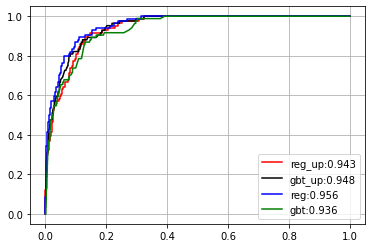

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_reg_up, tpr_reg_up, color = 'red', label=f"reg_up:{auc_reg_up:.3f}")
plt.plot(fpr_gbt_up, tpr_gbt_up, color = 'black', label=f"gbt_up:{auc_gbt_up:.3f}")
plt.plot(fpr_reg, tpr_reg, color = 'blue', label=f"reg:{auc_reg:.3f}")
plt.plot(fpr_gbt, tpr_gbt, color = 'green', label=f"gbt:{auc_gbt:.3f}")
plt.legend()
plt.grid()
plt.show()

In [13]:
# save predictions of upsampled reg model
predictions['predReg_up'] = test_scores[:,1]
predictions.to_csv("./data/predictions_up.csv", index=False)

In [14]:
# save predictions to csv
df = pd.read_csv("./data/predictions_train.csv")
df["predReg_up"] = logreg_up.predict_proba(train[train.columns[1:]])[:,1]
df.to_csv("./data/predictions_train_up.csv", index=False)

## Downsampling

In [15]:
# Upsample minority class
target = train_minority.shape[0]
downsampled = resample(train_majority, n_samples=target, random_state=0)

# Combine majority class with upsampled minority class
train_downsampled = pd.concat([downsampled, train_minority])

# Show new class counts
train_downsampled.returnLabel.value_counts()

1    205
0    205
Name: returnLabel, dtype: int64

In [16]:
train_downsampled.head()

,totalAmount,returnLabel,c_0,c_1,c_2,c_3,c_4,c_5,100,101,...,991,992,993,994,995,996,997,998,999,1000
2732,264,0,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10799,153,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9845,861,0,2,2,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
19648,237,0,0,0,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
13123,135,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
X_train = train_downsampled.drop("returnLabel", axis=1)
y_train = train_downsampled["returnLabel"]

In [18]:
logreg_up = LogisticRegression(max_iter=5000)
logreg_up.fit(X_train, y_train)
gbt_up = GradientBoostingClassifier()
gbt_up.fit(X_train, y_train)

GradientBoostingClassifier()

In [19]:
test_scores = logreg_up.predict_proba(X_test)
fpr_reg_up, tpr_reg_up, _ = metrics.roc_curve(y_test, test_scores[:,1])
auc_reg_up = metrics.auc(fpr_reg_up, tpr_reg_up)
test_scores = gbt_up.predict_proba(X_test)
fpr_gbt_up, tpr_gbt_up, _ = metrics.roc_curve(y_test, test_scores[:,1])
auc_gbt_up = metrics.auc(fpr_gbt_up, tpr_gbt_up)

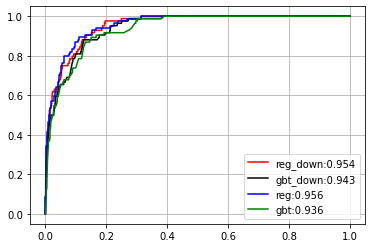

In [20]:
plt.figure()
plt.plot(fpr_reg_up, tpr_reg_up, color='red', label=f"reg_down:{auc_reg_up:.3f}")
plt.plot(fpr_gbt_up, tpr_gbt_up, color='black', label=f"gbt_down:{auc_gbt_up:.3f}")
plt.plot(fpr_reg, tpr_reg, color='blue', label=f"reg:{auc_reg:.3f}")
plt.plot(fpr_gbt, tpr_gbt, color='green', label=f"gbt:{auc_gbt:.3f}")
plt.legend()
plt.grid()
plt.show()

### SMOTE algorithm

In [21]:
from imblearn.over_sampling import SMOTE
X_train = train.drop("returnLabel", axis=1)
y_train = train["returnLabel"]

sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_resample(X_train, y_train)

logreg_sm = LogisticRegression(max_iter=5000)
logreg_sm.fit(X_res, y_res)

LogisticRegression(max_iter=5000)

In [22]:
test_scores = logreg_sm.predict_proba(X_test)
fpr_reg_sm, tpr_reg_sm, _ = metrics.roc_curve(y_test, test_scores[:,1])
auc_reg_sm = metrics.auc(fpr_reg_sm, tpr_reg_sm)

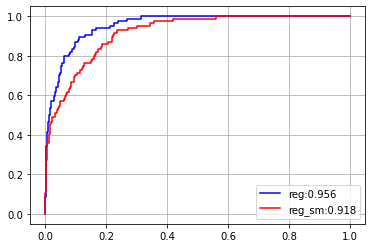

In [24]:
plt.figure()
plt.plot(fpr_reg, tpr_reg, color='blue', label=f"reg:{auc_reg:.3f}")
plt.plot(fpr_reg_sm, tpr_reg_sm, color='red', label=f"reg_sm:{auc_reg_sm:.3f}")
plt.legend()
plt.grid()
plt.show()